In [ ]:
#!pip install -U tensorflow-text==2.9.0

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.utils import class_weight
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv('/content/SMSSpamCollection.tsv', sep = '\t', names = ['target', 'text'])
data

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
data.target.value_counts()

ham     4825
spam     747
Name: target, dtype: int64

In [ ]:
data['target'] = data['target'].apply(lambda x: 1 if x == 'spam' else 0)

In [ ]:
data

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(data['text'], data['target'], test_size= 0.2, random_state = 4242)


In [ ]:
xtrain

3654    It has issues right now. Ill fix for her by to...
1897    I tot u outside cos darren say u come shopping...
2678    Where in abj are you serving. Are you staying ...
5122    NOT ENUFCREDEIT TOCALL.SHALL ILEAVE UNI AT 6 +...
3640                      Wat's da model num of ur phone?
                              ...                        
3254                  K:)k..its good:)when are you going?
657     Sun cant come to earth but send luv as rays. c...
653     Wait, do you know if wesleys in town? I bet sh...
494                    What class of  &lt;#&gt;  reunion?
942     Theyre doing it to lots of places. Only hospit...
Name: text, Length: 4457, dtype: object

**Using Bert model and preprocessor**

In [ ]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=False)

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
encoder_input = preprocessor(text_input)
outputs = encoder(encoder_input)
pooled_output = outputs['pooled_output'] # [batch_size, 768].
sequence_output = outputs['sequence_output'] # [batch_size, seq_length, 768].

In [ ]:
d1 = l1 = tf.keras.layers.Dropout(0.3, name='dropout')(pooled_output)
d2 = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'OUTPUT')(pooled_output)
model = tf.keras.Model(inputs = [text_input], outputs = [d2] )

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_type_ids':   0           ['input_3[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

In [ ]:
weights = class_weight.compute_class_weight(class_weight='balanced',classes= np.unique(ytrain),y= ytrain)
weights

array([0.57658473, 3.76435811])

In [ ]:
model.fit(xtrain, ytrain, epochs=3, validation_data=(xtest, ytest))

Epoch 1/3
140/140 [==============================] - 2873s 20s/step - loss: 0.3382 - accuracy: 0.8598 - val_loss: 0.2793 - val_accuracy: 0.8816
Epoch 2/3
140/140 [==============================] - 2740s 20s/step - loss: 0.2334 - accuracy: 0.8990 - val_loss: 0.2170 - val_accuracy: 0.8960
Epoch 3/3
140/140 [==============================] - 2745s 20s/step - loss: 0.1932 - accuracy: 0.9248 - val_loss: 0.1809 - val_accuracy: 0.9238


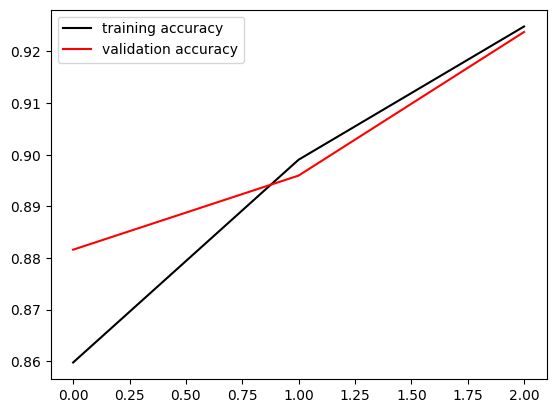

In [ ]:
plt.plot(model.history.history["accuracy"], label="training accuracy", color = 'black')
plt.plot(model.history.history["val_accuracy"], label="validation accuracy", color = 'red')
plt.legend()
plt.show()

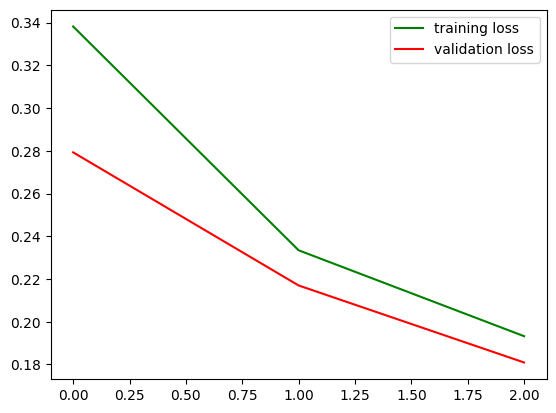

In [ ]:
plt.plot(model.history.history["loss"], label="training loss", color = 'green')
plt.plot(model.history.history["val_loss"], label="validation loss", color = 'red')
plt.legend()
plt.show()